# LightGBM（特徴量：ALL）の学習→予測→評価

In [1]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==3.3.5
# !pip install shap==0.41.0

In [2]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
import shap
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__) 
print(lgb.__version__)
print(shap.__version__)

1.5.3
1.22.4
3.7.1
1.2.2
3.3.5
0.41.0


In [4]:
# データセットの読み込み
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame
#df.head()

In [5]:
# 特徴量と目的変数の設定
X = df.drop(['MedHouseVal'], axis=1)
y = df['MedHouseVal']

In [6]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (16512, 8)  y_trainの形状： (16512,)  X_testの形状： (4128, 8)  y_testの形状： (4128,)


In [7]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)

params = {'objective': 'mse',
          'num_leaves': 5,
          'seed': 0,
          'verbose': -1,
}

In [8]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=50,
                  valid_sets=[lgb_train],
                  valid_names=['train'],
                  callbacks=[lgb.log_evaluation(10)])

[10]	train's l2: 0.691819
[20]	train's l2: 0.511272
[30]	train's l2: 0.409124
[40]	train's l2: 0.360521
[50]	train's l2: 0.335626


In [ ]:
# 学習データの予測と評価
y_train_pred = model.predict(X_train) 
print('MSE train: %.2f' % (mean_squared_error(y_train, y_train_pred)))
print('RMSE train: %.2f' % (mean_squared_error(y_train, y_train_pred) ** 0.5))

MSE train: 0.34
RMSE train: 0.58


In [ ]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test)
print('RMSE test: %.2f' % (mean_squared_error(y_test, y_test_pred) ** 0.5))

RMSE test: 0.59


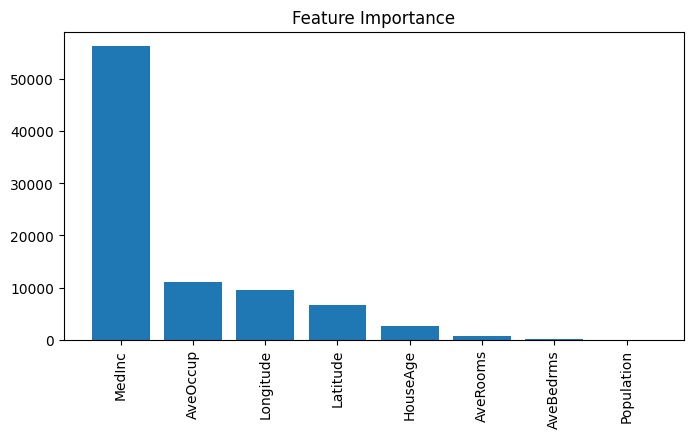

In [11]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

<Axes: >

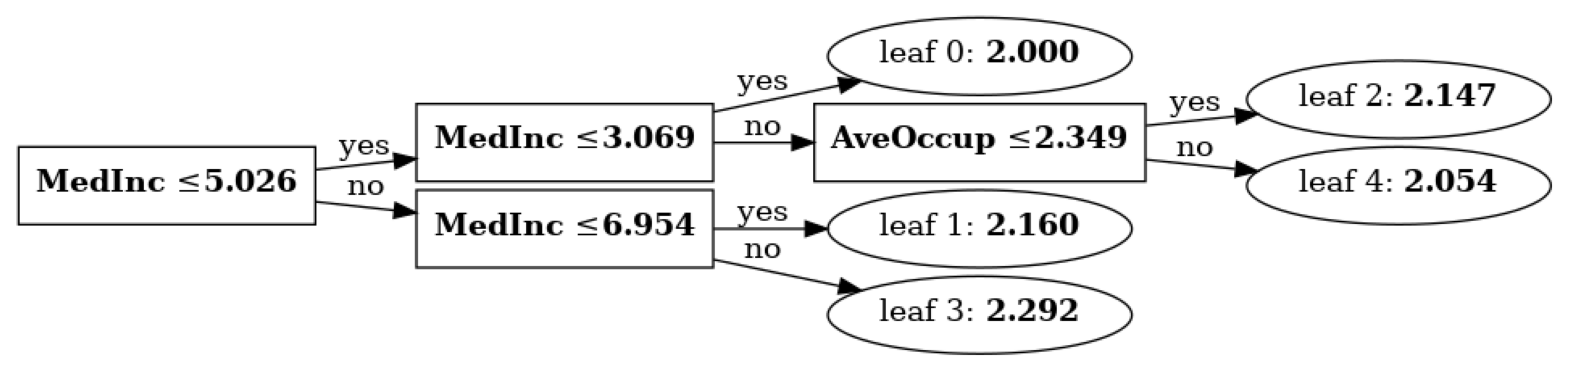

In [12]:
# 1本目の木の可視化
lgb.plot_tree(model, tree_index=0, figsize=(20, 20))

<Axes: >

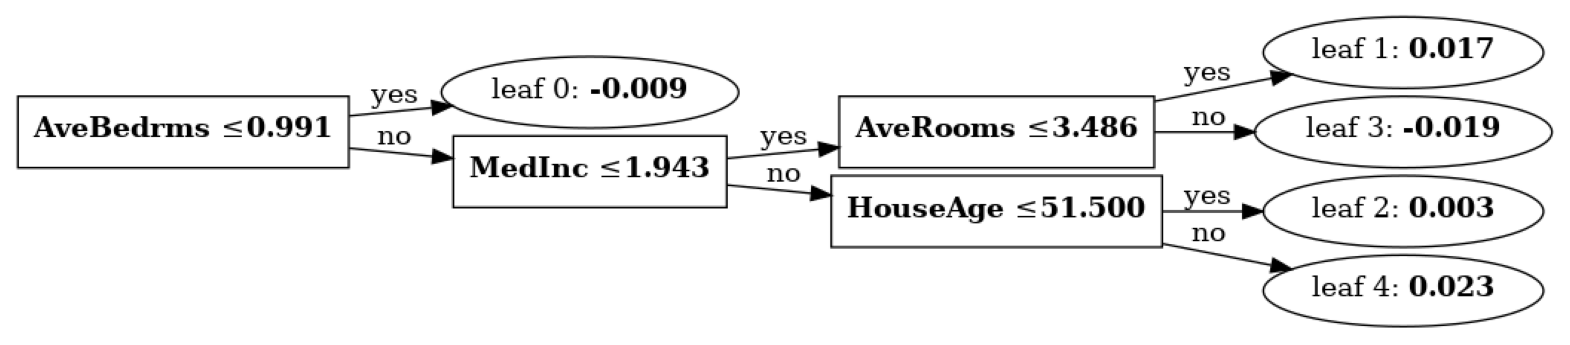

In [13]:
# 50本目の木の可視化
lgb.plot_tree(model, tree_index=-1, figsize=(20, 20))

# SHAP

In [14]:
# explainerの作成
import shap
explainer = shap.TreeExplainer(
    model = model,
    feature_perturbation = 'tree_path_dependent')

In [15]:
# # explainerの作成（interventional）
# import shap

# explainer = shap.TreeExplainer(
#     model = model,
#     data = X_test,
#     feature_perturbation = 'interventional')

In [16]:
# SHAP値の計算
shap_values = explainer(X_test)

In [17]:
# 全件レコードの期待値
explainer.expected_value

2.0724989589104235

In [18]:
# 予測値のリスト
y_test_pred

array([1.6302725 , 2.78321097, 1.66278898, ..., 1.20252496, 2.7755789 ,
       1.81427108])

In [19]:
# 15件目のSHAP値
shap_values[14]

.values =
array([ 0.056867  ,  0.01288572, -0.01586917,  0.01077845,  0.        ,
       -0.24826544,  0.24144761, -0.13829556])

.base_values =
2.0724989589104235

.data =
array([   4.4821    ,   33.        ,    6.22463768,    1.04347826,
        421.        ,    3.05072464,   34.15      , -117.94      ])

In [20]:
# 15件目の貢献度
shap_values.values[14]

array([ 0.056867  ,  0.01288572, -0.01586917,  0.01077845,  0.        ,
       -0.24826544,  0.24144761, -0.13829556])

In [21]:
# 15件目の貢献度合計
shap_values.values[14].sum()

-0.08045138233486704

In [22]:
# 期待値＋15件目の貢献度合計
shap_values[14].base_values + shap_values.values[14].sum()

1.9920475765755565

In [23]:
# 15件目の予測値
y_test_pred[14]

1.9920475765755563

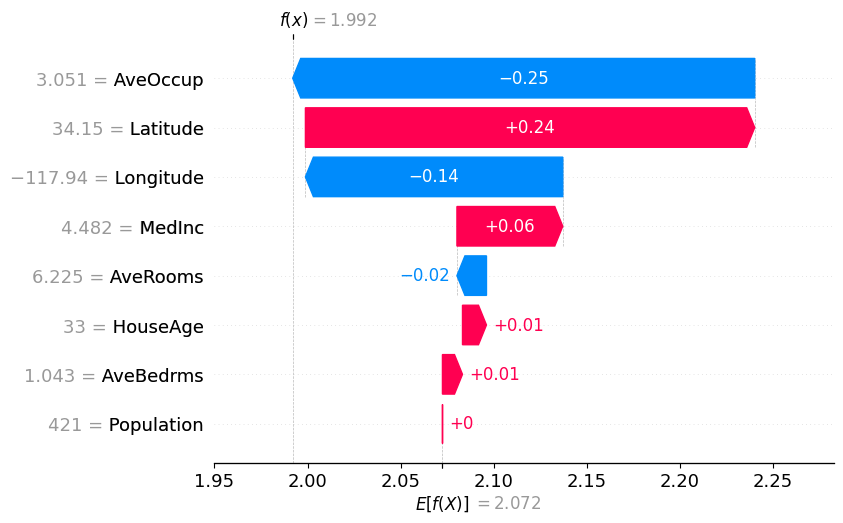

In [24]:
# 15件目のSHAP値の可視化
shap.plots.waterfall(shap_values[14])

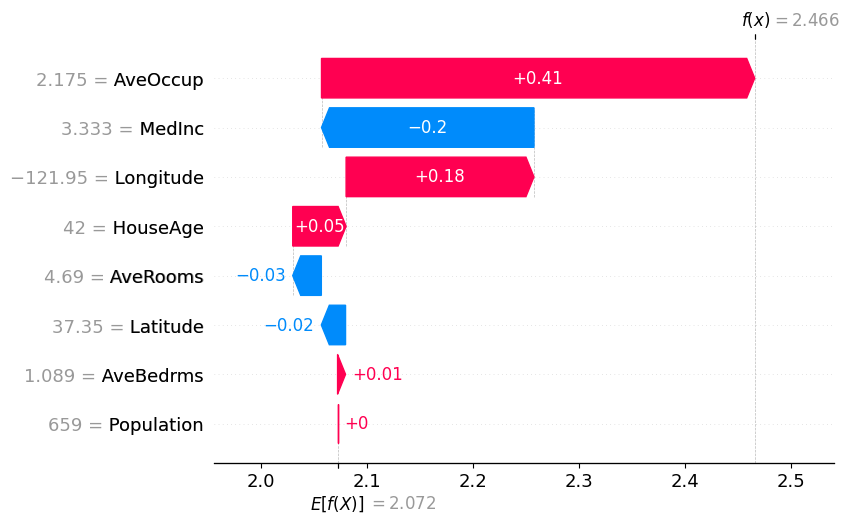

In [25]:
# 11件目のSHAP値の可視化
shap.plots.waterfall(shap_values[10])

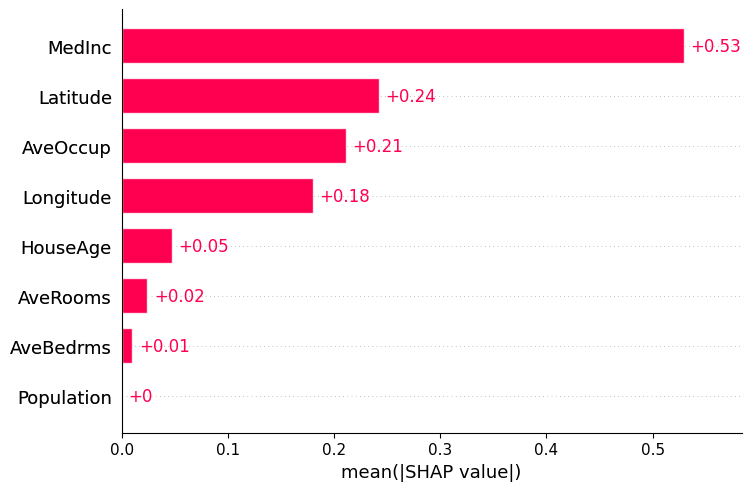

In [26]:
# 特徴量重要度の可視化
shap.plots.bar(shap_values=shap_values)